# TCGA 

## Initial Setup

Connects to Google Drive
Installs and imports dependancies
Run whether starting or returning

In [1]:
from multiprocessing import Process
import numpy as np
from numpy import asarray
import os
import pandas as pd
import shutil
from sys import platform
import glob
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import random 
from PIL import Image
plt.style.use("ggplot")
import gc
# import sklearn
from sklearn.model_selection import train_test_split
import pickle
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from IPython.display import clear_output
import torch.nn.utils.prune as prune
import time
import cv2
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import StratifiedKFold
import multiprocessing
import time


In [2]:
import os
process_count = len(os.sched_getaffinity(0))
print('Processors available: ', process_count)

Processors available:  32


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar  5 13:14:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:43:00.0 Off |                  N/A |
|  0%   29C    P8               5W / 300W |     17MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Working with tiles

Continue from here if resuming work


In [4]:
%cd CancerPrediction
df_reduced = pd.read_csv('slides/procesed_model_labels.csv')
label = 'ER_Label'
print(len(df_reduced))
df_reduced.head()


/home_ssd2/deanak/CancerPrediction
2673


,id,filename,brca_shared-pr_status_by_ihc,brca_shared-er_status_by_ihc,brca_shared-her2_status_by_ihc,Path,ER_Label,PR_Label,HER_Label,NNN_label,Tile_DF
0,b69e1106-0c5b-4fd2-bd00-f3aa3ea9eda8,TCGA-BH-A18V-06A-01-TSA.BEF73FC6-FB7D-47EE-867...,Negative,Negative,Negative,/slides/b69e1106-0c5b-4fd2-bd00-f3aa3ea9eda8/t...,0,0,0,1,slides/b69e1106-0c5b-4fd2-bd00-f3aa3ea9eda8/ti...
1,fd339777-4def-4466-8fee-9762b7bab9f9,TCGA-C8-A12L-01A-01-BSA.f97cb175-3951-4f67-ac5...,Negative,Negative,Equivocal,/slides/fd339777-4def-4466-8fee-9762b7bab9f9/t...,0,0,2,0,slides/fd339777-4def-4466-8fee-9762b7bab9f9/ti...
2,ba56d49e-1907-44fd-93aa-34bfc566dd59,TCGA-AN-A0XT-01A-01-TSA.14d9f5ee-14a2-4049-935...,Negative,Positive,Negative,/slides/ba56d49e-1907-44fd-93aa-34bfc566dd59/t...,1,0,0,0,slides/ba56d49e-1907-44fd-93aa-34bfc566dd59/ti...
3,ca7e0d59-7c28-41ba-8c55-59b69ab80d07,TCGA-A8-A091-01A-01-TS1.c06440ae-88c4-4ed8-a1b...,Negative,Positive,Negative,/slides/ca7e0d59-7c28-41ba-8c55-59b69ab80d07/t...,1,0,0,0,slides/ca7e0d59-7c28-41ba-8c55-59b69ab80d07/ti...
4,f668d072-2b1e-4d18-a746-3229088fb799,TCGA-A7-A13E-01B-06-BS6.4796C3A1-71ED-4757-B9E...,Negative,Positive,Equivocal,/slides/f668d072-2b1e-4d18-a746-3229088fb799/t...,1,0,2,0,slides/f668d072-2b1e-4d18-a746-3229088fb799/ti...


In [5]:
patient_id = []
df = df_reduced
for idx, row in df.iterrows():
    patient_id.append(row.filename[0:12])
df['patient_id'] = patient_id
patient_count = df.patient_id.nunique()
print(f'{len(df)} WSIs from {patient_count} patients.')

2673 WSIs from 1088 patients.


### Get average dataset pixel value image

In [6]:
### Get average values for each pixel across dataset ###
# def process_image(start, end, shared_result):
#     local_avg = 0
#     for i in range(start, end):
#         # Perform your computation here and add it to local_result
#         df = pd.read_csv(df_reduced.iloc[i].Tile_DF)
#         for idx, r in df.iterrows():
#             img = Image.open(r.TilePath).convert('RGB')
#             # Open and process the image
#             # Split the image into its color channels
#             red_channel, green_channel, blue_channel = img.split()

#             # Calculate the sum of pixel values for each channel
#             sum_red = sum(red_channel.getdata())
#             sum_green = sum(green_channel.getdata())
#             sum_blue = sum(blue_channel.getdata())

#             # Add the sums to the shared result
#             with shared_result.get_lock():
#                 shared_result[0] += sum_red
#                 shared_result[1] += sum_green
#                 shared_result[2] += sum_blue


# num_processes = multiprocessing.cpu_count()  # Number of CPU cores
# print(num_processes)
# num_iterations = len(df_reduced)
# # Initialize a shared result for R, G, and B channels
# shared_result = multiprocessing.Array('l', [0, 0, 0])

# # Split the work into chunks for each process
# chunk_size = len(df_reduced) // num_processes
# processes = []
# tic = time.time()
# for i in range(num_processes):
#     start = i * chunk_size
#     end = (i + 1) * chunk_size if i < num_processes - 1 else len(df_reduced)
#     p = multiprocessing.Process(target=process_image, args=(start, end, shared_result))
#     processes.append(p)
#     p.start()

# # Wait for all processes to complete
# for p in processes:
#     p.join()

# # Count number of tiles in dataset
# num_images = 0
# for ind, row in df_reduced.iterrows():
#     num_images += len(pd.read_csv(row.Tile_DF))
# print(num_images)

# # Calculate the overall average pixel values for R, G, and B channels
# total_red, total_green, total_blue = shared_result
# average_red = total_red / (num_images * chunk_size) / (256 * 256)
# average_green = total_green / (num_images * chunk_size) / (256 * 256)
# average_blue = total_blue / (num_images * chunk_size) / (256 * 256)

# print(f"Average Red: {average_red}")
# print(f"Average Green: {average_green}")
# print(f"Average Blue: {average_blue}")

# # Example RGB channels as NumPy arrays (replace with your own data)
# red_channel = np.full((256, 256), average_red, dtype=np.uint8)
# green_channel = np.full((256, 256), average_green, dtype=np.uint8)
# blue_channel = np.full((256, 256), average_blue, dtype=np.uint8)

# # Stack the channels to create a single RGB image
# rgb_image = np.stack((red_channel, green_channel, blue_channel), axis=-1)

# # Convert the NumPy array to a PIL image
# image = Image.fromarray(rgb_image)
# print(f'Time to process: {round((time.time() - tic) / 60, 3)} minutes.)
# # Save or display the image
# image.save('avg_data_image.jpg')
# image

In [7]:
### Form solid image of average pixel values
# img = Image.open('avg_data_image.jpg')
# pavg = np.around(np.average(img, axis = (0,1)),0).astype(np.uint8)
# print(pavg)
# transform = T.Compose([T.ToTensor(),
#                        T.RandomErasing(p=1, scale=(1,1), ratio=(1, 1), value=(pavg[0], pavg[1], pavg[2]), inplace=False),
#                        T.ToPILImage()])
# # apply the transform on image
# img = transform(img)
# img.save('avg_data_image.jpg')
# img

### Build training/validation/test data sets

In [8]:
df_reduced = df_reduced[~df_reduced[label].isin([2])]
######  ONLY UNCOMMENT IF YOU WANT TO CHANGE TRAIN/TEST DATASETS ######
# df_train, df_test = train_test_split(df_reduced, test_size=0.2, stratify=df_reduced[label])

# folders = ['train', 'test']
# dataframes = [df_train, df_test]
# for folder in folders:
#     dataframes[folders.index(folder)].index = range(len(dataframes[folders.index(folder)].index))
#     dataframes[folders.index(folder)] = dataframes[folders.index(folder)].loc[:, ~dataframes[folders.index(folder)].columns.str.contains(dataframes[folders.index(folder)].columns.tolist()[0])]
#     dataframes[folders.index(folder)].to_csv(f'df_{folder}_{label}.csv')

# df_train = dataframes[0]
# df_test = dataframes[1]
df_train = pd.read_csv(f'df_train_{label}.csv')
df_test = pd.read_csv(f'df_test_{label}.csv')
df_train[label].value_counts()


ER_Label
1    1568
0     476
Name: count, dtype: int64

## MIL Model

### Preview tile data

WSI index:2474, WSi ID: bb946f8d-e6da-4b50-895d-9b432ec7a33f, Label: 1, Number of tiles: 485, Tile index shown: 144
The image is not blurry.


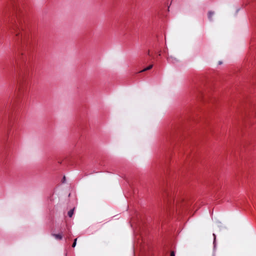

In [9]:
def is_blurry(image, threshold=100):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the Laplacian of the image
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    # Check if the variance is below the threshold
    return laplacian_var < threshold

# bag_index = 867
bag_index =  random.randint(0, len(df_reduced))
# bag_index = df_reduced.index[df_reduced.id == '4aa6bbd5-7b99-4261-bbb7-6372b78a5aa9'].tolist()[0]
# bag_index
tile_df = pd.read_csv(df_reduced.iloc[bag_index]['Tile_DF'])
tile_index = random.randint(0, len(tile_df) - 1)
# tile_index = 50
print(f'WSI index:{bag_index}, WSi ID: {df_reduced.iloc[bag_index].id}, Label: {df_reduced.iloc[bag_index][label]}, Number of tiles: {len(tile_df)}, Tile index shown: {tile_index}')
tile = tile_df.iloc[tile_index]['TilePath']
img = Image.open(tile).convert('RGB')


angles = [0, 90, 180, 270]
degrees= angles[random.randrange(len(angles))]
transform = T.Compose([T.ToTensor(),
                       # T.RandomHorizontalFlip(),
                       # T.RandomRotation((degrees,degrees)),
                       # T.RandomAdjustSharpness(2, p=0.5),
                       # T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                       # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       # T.RandomErasing(p=1, scale=(0.39, 0.39), ratio=(1, 1), value=0, inplace=False),
                       T.ToPILImage()])
# apply the transform on image
img = transform(img)
img_arr = np.array(img)

# Check if the image is blurry
if is_blurry(img_arr):
    print("The image is blurry.")
else:
    print("The image is not blurry.")

# display the output image
img

## PyTorch Model

### Bag Creator

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



class MILDataset(Dataset):
    def __init__(self, dataframe, n_tiles, transformation, test):
        self.dataframe = dataframe
        self.transform = transformation
        self.n_tiles = n_tiles
        self.test = test

    def __len__(self):
        return len(self.dataframe)
    
    
    def __getitem__(self, index):
        bag_filepath = self.dataframe.iloc[index]['Tile_DF']
        if not self.test:
            bag_label = self.dataframe.iloc[index][label]
        df_tile_list = []
        # Load bag of tiles
        df_tiles = pd.read_csv(bag_filepath)
        bag_of_tiles = []
        
        max_n = len(df_tiles)
        if self.n_tiles > max_n:
            n_tiles = max_n
        else:
            n_tiles = self.n_tiles
        tile_index = np.random.choice(len(df_tiles), n_tiles, replace=False)
        for i in range(n_tiles):
            # Load image using PIL
            ran = random.uniform(0, 1)
            if ran <= 0.25 or self.transform == test_transform:
                image = Image.open(df_tiles.loc[tile_index[i]]['TilePath']).convert('RGB')
                df_tile_list.append(df_tiles.loc[tile_index[i]].tolist())
            else:
                image = Image.open('avg_data_image.jpg')
            # Apply transformations if provided
            if self.transform is not None:
                image = self.transform(image)

            bag_of_tiles.append(image)

        bag_of_tiles = torch.stack(bag_of_tiles)

        if self.test:
            return bag_of_tiles
        else:
            return bag_of_tiles, bag_label, df_tile_list


angles = [0, 90, 180, 270]

degrees= angles[random.randrange(len(angles))]
train_transform = T.Compose([T.ToTensor(),
                       T.RandomHorizontalFlip(),
                       T.RandomRotation((degrees,degrees)),
                       T.RandomVerticalFlip(),
                       T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       T.RandomErasing(p=1, scale=(0.39, 0.39), ratio=(1, 1), value=0, inplace=False),
                       ])

test_transform = T.Compose([T.ToTensor()])

batch_size = 1

# Define the number of classes
num_classes = 2                 

### PyTorch Resnet Model

In [11]:
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import resnet18, resnet50, resnet101, resnet152, ResNet18_Weights, ResNet50_Weights, ResNet101_Weights, ResNet152_Weights, resnext50_32x4d, ResNeXt50_32X4D_Weights, resnext101_64x4d, ResNeXt101_64X4D_Weights
from torchvision.models import DenseNet121_Weights, DenseNet169_Weights, DenseNet201_Weights
import timm

class MILModel(nn.Module):
    def __init__(self):
        super(MILModel, self).__init__()
        # Define your model architecture here
        self.L1 = 1024 # 1024 node fully connected layer
        self.L = 512 # 512 node fully connected layer
        self.D = 128 # 128 node attention layer
        self.K = 1
        self.resnet_list = [[resnet18(weights=ResNet18_Weights.IMAGENET1K_V1), 'Resnet18'],
                            # [resnet50(weights=ResNet50_Weights.IMAGENET1K_V2), 'ResNet50'],
                            # [resnet101(weights=ResNet101_Weights.IMAGENET1K_V2), 'ResNet101'],
                            # [resnet152(weights=ResNet152_Weights.IMAGENET1K_V2), 'ResNet152'],
                            # [resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V2), 'ResNeXt50_32x4d'],
                            # [resnext101_64x4d(weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1), 'ResNeXt101_64x4d'],
                            # [torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_se_resnext101_32x4d'), 'SE_ResNext101_32x4d'],
                            # [timm.create_model('seresnextaa101d_32x8d.sw_in12k_ft_in1k_288', pretrained=True), 'SE_ResNext101_32x8d'],
                            [timm.create_model('seresnext50_32x4d', pretrained=True),'SE_ResNeXt50_32x4d']
                            # [torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_se_resnext101_32x4d'), 'SE_ResNeXt101_32x4d']
                        ]
        self.densenet_list = [#[torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights=DenseNet121_Weights.IMAGENET1K_V1), 'DenseNet121'],
                            # [torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', weights=DenseNet169_Weights.IMAGENET1K_V1), 'DenseNet169'],
                            [torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', weights=DenseNet201_Weights.IMAGENET1K_V1), 'DenseNet201']
                            ]
        
        #Choose model
        self.choice = self.resnet_list[1]
        # self.choice = self.densenet_list[0]
        self.model = self.choice[0]
        self.name = self.choice[1]        # self.model = self.densenet_list[0]
        
        if self.choice in self.resnet_list:
            self.num_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Identity(),
                nn.Linear(self.num_features, self.L1),
                nn.Dropout(0.5, False),
                nn.Linear(self.L1, self.L),
                nn.Dropout(0.5, False)
            )
            nn.init.kaiming_normal_(self.model.fc[1].weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.model.fc[3].weight, mode='fan_in', nonlinearity='relu')
            
        elif self.choice in self.densenet_list:
            self.num_features = self.model.classifier.in_features
            # self.model.classifier = nn.Linear(self.num_features, 1)
            self.pool = nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
                nn.Flatten()
            )
            self.linear_layers = nn.Sequential(
                nn.Identity(),
                # nn.Flatten(),
                nn.Linear(self.num_features, self.L1),
                nn.Dropout(0.5, False),
                nn.Linear(self.L1, self.L),
                nn.Dropout(0.5, False)
            )
            nn.init.kaiming_normal_(self.linear_layers[1].weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.linear_layers[3].weight, mode='fan_in', nonlinearity='relu')
        
        self.drop = nn.Dropout(0.5, False)
   
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifierBCE = nn.Sequential(
            nn.Linear(self.L, 1),
            nn.Sigmoid()
        )

        self.classifierBCEL = nn.Sequential(
            nn.Linear(self.L, 1),
        )
        
    def forward(self, bag):
        # Compute the representation of bags_of_tiles
        # Process each bag of tiles to get a single representation
        if self.choice in self.resnet_list:
            x = self.model(bag)
            
        elif self.choice in self.densenet_list:
            x = self.model.features(bag)
            x = self.pool(x)
            x = self.linear_layers(x)
                           

        A = self.attention(x) # NxK
        A = torch.transpose(A, 1, 0) # KxN
        A = F.softmax(A, dim=1) # softmax over N
        M = torch.mm(A, x)
        if criterion == nn.BCELoss:
            out = self.classifierBCE(M)
        else:
            out = self.classifierBCEL(M)        
        return out


### Model

In [12]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

# Use AMP for mixed precision training
scaler = GradScaler()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.
    correct = 0
    total = 0
    tic = time.time()
    pred_array = []
    label_array = []
    prob_array = []
    print(f'Epoch: {epoch}/{num_epochs}')
    loop = tqdm(train_loader)
    for idx, batch in enumerate(loop):
        data, label, df_tiles = batch
        label_array.append(label[0].item())
        data = torch.squeeze(data)
        data, label = Variable(data), Variable(label)
        data, label = data.to(device), label.to(device)
        # reset gradients
        optimizer.zero_grad()
        # calculate, loss, and predictions
        # Forward pass
        with autocast():  # Enables automatic mixed precision
            out = model.forward(data)
            if criterion == nn.BCELoss:
                y_prob = out
                loss = criterion(torch.squeeze(y_prob,1).float(), label.float())
                if label.item() > 0 and y_prob.item() < threshold:
                    loss += criterion(torch.squeeze(y_prob,1).float(), label.float())
            else: 
                loss = criterion(torch.squeeze(out,1).float(), label.float())
                # loss = criterion(np.asarray([out.item()]), label.float())
                y_prob = torch.sigmoid(out)
                if class1 < class0:
                    if label.item() > 0 and y_prob.item() < threshold:
                        loss += criterion(torch.squeeze(out,1).float(), label.float())
                else:
                    if label.item() < 0 and y_prob.item() > threshold:
                        loss += criterion(torch.squeeze(out,1).float(), label.float())
                        
        # y_prob, y_hat = model.forward(data)
        y_hat = torch.ge(y_prob, threshold).float()
        pred_array.append(y_hat.item())
        prob_array.append(y_prob.item())
        total += 1
        if y_hat == label:
            correct += 1
        train_loss += loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        
    toc = time.time()
    
    roc_auc = round(roc_auc_score(np.asarray(label_array), np.asarray(prob_array)), 4)
    # calculate loss and error for epoch
    total_loss = round(train_loss.cpu().float().data.item() / len(train_loader), 4)
    accuracy =  round(correct / total, 4)
    print(f'Train Set, Avg. Loss: {total_loss}, Accuracy: {accuracy}, AUROC: {roc_auc}, Train time: {round(toc-tic)}s')
   
    return total_loss, accuracy, roc_auc

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0.
    correct = 0
    total = 0
    label_array = []
    pred_array = []
    prob_array = []
    with torch.no_grad():
        tic = time.time()
        loop = tqdm(test_loader)
        for idx, batch in enumerate(loop):
            data, label, df_tiles = batch
            data = torch.squeeze(data)
            label_array.append(label.item())
            data, label = Variable(data), Variable(label)
            data, label = data.to(device), label.to(device)
            # reset gradients
            optimizer.zero_grad()
            # calculate, loss, and predictions
            with autocast():  # Enables automatic mixed precision
                out = model.forward(data)
                if criterion == nn.BCELoss:
                    y_prob = out
                    loss = criterion(torch.squeeze(y_prob,1).float(), label.float())
                else: 
                    loss = criterion(torch.squeeze(out,1).float(), label.float())
                    y_prob = torch.sigmoid(out)
            total += 1
            y_hat = torch.ge(y_prob, threshold).float()
            if y_hat == label:
                correct += 1
            pred_array.append(y_hat.item())
            prob_array.append(y_prob.item())
            test_loss += loss
            
        toc = time.time()
        roc_auc = round(roc_auc_score(np.asarray(label_array), np.asarray(prob_array), average='micro'), 4)
        # calculate loss and error for epoch
        total_loss = round(test_loss.cpu().float().data.item() / len(test_loader), 4)
        accuracy =  round(correct / total, 4)
        print(f'Avg. Loss: {total_loss}, Accuracy: {accuracy}, AUROC: {roc_auc}, Val time: {round(toc-tic)}s')
        return total_loss, accuracy, roc_auc, pred_array, label_array, prob_array

def test(model, device, test_loader):
    model.eval()
    pred_array = []
    with torch.no_grad():
        loop = tqdm(test_loader)
        for idx, batch in enumerate(loop):
            data = Variable(torch.squeeze(batch))
            data = data.to(device)
            # reset gradients
            optimizer.zero_grad()
            # calculate, loss, and predictions
            with autocast():  # Enables automatic mixed precision
                out = model.forward(data)
                if criterion == nn.BCELoss:
                    y_prob = out
                else: 
                    y_prob = torch.sigmoid(out)
            y_hat = torch.ge(y_prob, threshold).float()
            pred_array.append(y_hat.item())
            
        
        return pred_array



## Run Model

### Find optimal worker number for data loader. UNCOMMENT FOR USE IN NEW MACHINE

In [13]:
# from time import time
# import multiprocessing as mp
# df_1 = c1.sample(s_num, replace=replace)
# df_0 = c0.sample(s_num, replace=replace)
# df_epoch_train = pd.concat([df_1, df_0], axis=0)
# df_epoch_train = df_epoch_train.reset_index(drop=True)
# n_tiles = 50
# workers = pd.DataFrame(columns=['workers', 'time'])
# train_dataset = MILDataset(df_epoch_train, n_tiles, train_transform, False)
# for num_workers in range(12, 22,2):#mp.cpu_count(), 2):  
#     train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
#     start = time()
#     for epoch in range(1, 3):
#         for i, data in enumerate(train_dataloader, 0):
#             pass
#     end = time()
#     workers.loc[len(workers)] = [num_workers, end - start]
#     print(f"Finished with:{round(end - start, 2)} seconds, num_workers={num_workers}")
# workers.to_csv('num_workers.csv')

### Iinitiate model

In [23]:
### Definitions ###
def accuracy(predictions, labels):
    count = 0
    for i in range(len(labels)):
        if predictions[i] == labels[i]:
            count += 1
    return count / len(labels)

def test_metrics(actual, df, choice, type):
    if choice == 'max':
        df['Prediction'] = df.max(axis=1)   
    elif choice == 'min':
        df['Prediction'] = df.min(axis=1)   
    else:
        df['avg'] = df.sum(axis=1) / df.count(axis='columns')
        df['Prediction'] = df.avg.agg(lambda x: 1 if x >= 0.5 else 0)
    df['label'] = actual
    df.to_csv(f'{type}_{choice}_predictions.csv')
    predictions = df.Prediction.tolist()

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(val_labels, predictions)
    
    # Calculate Youden's J statistic for each threshold
    youden_j = tpr - fpr
    
    # Find the threshold that maximizes Youden's J statistic
    best_threshold = thresholds[np.argmax(youden_j)]


    binarized_array = np.where(np.array(predictions) >= best_threshold, 1, 0)
    e_acc = round(accuracy(binarized_array, actual),4)
    e_roc_auc = round(roc_auc_score(np.asarray(actual), np.asarray(predictions), average='micro'), 4)
    # Calculate confusion matrix
    cm = confusion_matrix(actual, binarized_array)
    # Extract values from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    # Calculate sensitivity (recall)
    sensi = tp / (tp + fn)
    # Calculate specificity
    speci = tn / (tn + fp)

    print(cm)
    print(f'Test ensemble Accuracy: {e_acc}, AUROC: {e_roc_auc} using {choice} as the selector.')
    return e_acc, e_roc_auc, sensi, speci

def save_ckp(state, checkpoint_dir, is_best):
    if is_best == True:
        f_path = f'{checkpoint_dir}/best_checkpoint-{date}_{label}.pt'
    else:
        f_path = f'{checkpoint_dir}/checkpoint-{date}_{label}.pt'
    torch.save(state, f_path)
    

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch'], checkpoint['statistics'], checkpoint['best_auc'], checkpoint['best_epoch'], checkpoint['ensemble_imp'], checkpoint['last_fold'], checkpoint['fold_score'], checkpoint['early_stopper']

def create_checkpoint(epoch, model, optimizer, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, last_fold, fold_score, early_stopper):
    checkpoint = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'statistics': stats,
            'best_auc': best_val_auc,
            'best_epoch': best_val_auc_epoch,
            'ensemble_imp': ensemble_improvement,
            'last_fold': last_fold,
            'fold_score': fold_score,
            'early_stopper': early_stopper
    }
    return checkpoint

def print_roll_avg(x, y):
    blue_color = '\033[94m'
    reset_color = '\033[0m'
    print(f'Rolling Best Cross-validation Scores: [',end = '')
    for i in x:
        print(i, end=', ')
    print(f'{blue_color}{y}{reset_color}]')
    print(f'Rolling Best Cross-validation Average: {round((sum(x)+ y) / (len(x) + 1), 4)}\n')


class ClassBalancedLoss(torch.nn.Module):
    def __init__(self, gamma=1.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, target):
        eps = 1e-12
        count = target.float().sum(dim=0)
        weight = (1 - count / count.sum()) ** self.gamma
        weight = weight / weight.sum()
        loss = weight * torch.nn.BCEWithLogitsLoss()(logits, target)
        return loss

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.train_losses = []
        self.val_losses = []
        self.avg_t_loss = 0
        self.avg_v_loss = 0
        
    def print_stop_status(self):
        print(f'Early stop status: {self.counter}/{self.patience}')
        print(f'Last 10 average Train Loss: {self.avg_t_loss}')
        print(f'Last 10 average Val   Loss: {self.avg_v_loss}')
        
    def early_stop(self, v_loss, t_loss):
        self.train_losses.append(t_loss)
        self.val_losses.append(v_loss)
        if len(self.train_losses) > 10:
            del self.train_losses[0]
            del self.val_losses[0]
        if v_loss < self.min_validation_loss:
            self.min_validation_loss = v_loss
            self.counter = 0
        if v_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            self.print_stop_status()
            if self.counter >= self.patience:
                return True
        self.avg_t_loss = sum(self.train_losses) / len(self.train_losses)
        self.avg_v_loss = sum(self.val_losses) / len(self.val_losses)
        if (self.avg_v_loss - self.avg_t_loss) > 0.35 and len(self.train_losses) == 10 and epoch > 50:
            return True
        return False
    

In [15]:
######### Initializers
checkpoint_dir = 'checkpoints' # Directory to save checkpoints to
num_epochs = 300 # Number of epochs to train on
n_tiles = 50
n_tiles_val = 500
date = '3-4' # Checkpoint date
ckp_path = f"checkpoints/checkpoint-{date}_{label}.pt"
e_choice = 'max' # How to select ensemble prediction
is_best = False # Best model so far?
restart = False # Restarting from a current epoch?
num_vals = 1 # number of ensemble member runs
threshold = 0.5 # y_hat probability threshold
df_num_workers = pd.read_csv('num_workers.csv')
num_workers = int(df_num_workers.workers.iloc[df_num_workers.time.idxmin()])

# Class size determination
if df_train[label].value_counts().index.tolist()[0] == 1:
    class1, class0 = df_train[label].value_counts()
else:
    class0, class1 = df_train[label].value_counts()

# Number of splits (k)
k_folds = 5
print(num_workers)
########## Create the MIL model
# model = MILGatedModel()
model = MILModel()
model.name += F'_{label}'

########### Define the loss criterion
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
# criterion = ClassBalancedLoss()

# ############ Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=5e-5)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
print(f'Running the model on {device}')
model.to(device)
print(f'Ready to go!')

18


Using cache found in /home_ssd2/deanak/.cache/torch/hub/pytorch_vision_v0.10.0


Running the model on cuda
Ready to go!


### Begin Cross-validation Training

In [64]:
# Restart from the previous checkpoint?
if restart:
    model, optimizer, start_epoch, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, last_fold, fold_score, early_stopper = load_ckp(ckp_path, model, optimizer)
    model.to(device)
    
else: 
    start_epoch = 1
    best_val_auc = 0
    best_val_auc_epoch = 0
    ensemble_improvement = []
    stats = [[],[],[],[],[],[],[]] # [train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs, ensemble_auc] 
    fold_score = []
    last_fold = 0
    early_stopper = EarlyStopper(patience=10, min_delta=0.6)


# Initialize KFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(skf.split(df_train, df_train[label])):
    clear_output(wait=True)
    if restart == True:
        print(f'Resuming {model.name} model from epoch: {start_epoch}')

    if fold < last_fold:
        pass
    else:
        try:
            ############## Save data ############
            checkpoint = create_checkpoint(epoch, model, optimizer, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, fold, fold_score, early_stopper)
            save_ckp(checkpoint, checkpoint_dir, False)
        except NameError:
            pass
        
        print(f'Start Training with {model.name}')
        df_cross_train = df_train.iloc[train_index]
        df_cross_val = df_train.iloc[val_index]
        if df_cross_train[label].value_counts().index.tolist()[0] == 1:
            class1, class0 = df_cross_train[label].value_counts()
        else:
            class0, class1 = df_cross_train[label].value_counts()
        c1 = df_cross_train[df_cross_train[label] == 1]
        c0 = df_cross_train[df_cross_train[label] == 0]
        sample = 'Und' # sampling type
        s_num = 1
        
        if sample == 'Ov':
             # Basic even sampling of training data using oversampling, based on the fewest label count
            if class0 >= class1:
                s_num = class0
            else: 
                s_num = class1
            replace = True  
        else:
            # Basic even sampling of training data using undersampling, based on the fewest label count
            if class0 <= class1:
                s_num = class0
            else: 
                s_num = class1
            replace = False
        
        df_1 = c1.sample(s_num, replace=replace)
        df_0 = c0.sample(s_num, replace=replace)
        df_epoch_train = pd.concat([df_1, df_0], axis=0)
        df_epoch_train = df_epoch_train.reset_index(drop=True)
        df_epoch_train[label].value_counts()   
        
        # Begin training
        for epoch in range(start_epoch, num_epochs + 1):
            print(f"Fold {fold + 1}/{k_folds}")
            print_roll_avg(fold_score, best_val_auc)
            
            print(f'{sample}ersampled Training Set')
            
            
            if sample == 'Und':
                df_1 = c1.sample(s_num, replace=replace)
                df_0 = c0.sample(s_num, replace=replace)
                df_epoch_train = pd.concat([df_1, df_0], axis=0)
                df_epoch_train = df_epoch_train.reset_index(drop=True)
            if epoch > 1:
                print(f'Continuing training with {model.name}')
            # # Build training dataloader
            train_dataset = MILDataset(df_epoch_train, n_tiles, train_transform, False)
            train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
            # train model
            train_loss, train_acc, train_auc = train(model, device, train_dataloader, optimizer, epoch)
            print(torch.cuda.max_memory_allocated(device=None) / (1024 ** 2))
            # Test the model on validation data
            print(f'Running {num_vals} tests on validation data.')
            losses = []
            accs = []
            aucs = []
            labels = []
            
            df_trials = pd.DataFrame()
            for run in range(num_vals): # Run several validations to account for random tile selections
                # Build validation dataloader
                val_dataset = MILDataset(df_cross_val, n_tiles_val, test_transform, False)    
                val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
                val_loss, val_acc, val_auc, val_preds, val_labels, val_prob = validate(model, device, val_dataloader)
                losses.append(val_loss)
                accs.append(val_acc)
                aucs.append(val_auc)
                df_trials[run] = val_prob
                
            avg_val_loss = round(sum(losses) / len(losses), 4)
            avg_val_acc = round(sum(accs) / len(accs), 4)
            avg_val_auc = round(sum(aucs) / len(aucs), 4)
            time.sleep(5)
            if epoch < num_epochs:
                clear_output(wait=True)
            print(f'  Average validation scores: Loss = {avg_val_loss}, Acc = {avg_val_acc}, AUROC = {avg_val_auc}')

            # Ensemble prediction
            e_acc, e_roc_auc, sens, spec = test_metrics(df_cross_val[label].tolist(), df_trials, e_choice, 'validation')
            improved = 100*round(e_roc_auc - avg_val_auc,3)
            ensemble_improvement.append(improved)
            if avg_val_auc >= best_val_auc:
                best_val_auc = avg_val_auc
                best_val_auc_epoch = epoch
                is_best = True
                checkpoint = create_checkpoint(epoch, model, optimizer, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, fold, fold_score, early_stopper)
                save_ckp(checkpoint, checkpoint_dir, is_best)
            else:
                 is_best = False   
        
            
            avg_e_improv = round(sum(ensemble_improvement) / len(ensemble_improvement),3)
        
            print(f'Best average AUROC: {best_val_auc} at epoch: {best_val_auc_epoch} Average Ensemble Improvement: {avg_e_improv} points')
        
            stats[0].append(train_loss)
            stats[1].append(train_acc)
            stats[2].append(train_auc)
            stats[3].append(avg_val_loss)
            stats[4].append(avg_val_acc)
            stats[5].append(avg_val_auc)
            stats[6].append(e_roc_auc)

            # Plot the results
            figure, axis = plt.subplots(1, 3)
            axis[0].plot(range(epoch), stats[0], label = 'train')
            axis[0].plot(range(epoch), stats[3], label = 'val')
            axis[0].set_title('Loss')
            axis[0].set_xlabel('Epoch')
            axis[1].plot(range(epoch), stats[1], label = 'train')
            axis[1].plot(range(epoch), stats[4], label = 'val')
            axis[1].set_title('Accuracy')
            axis[1].set_xlabel('Epoch')
            axis[2].plot(range(epoch), stats[2], label = 'train')
            axis[2].plot(range(epoch), stats[5], label = 'val')
            axis[2].plot(range(epoch), stats[6], label = 'ensemble')
            axis[2].set_title('AUROC')
            axis[2].set_xlabel('Epoch')
            plt.legend()
            plt.savefig(f'figures/{model.name}_fold{fold+1}.png')
            plt.show()

            early_stopper.print_stop_status()

            # Save metrics
            print(f'Saving metrics...')
            checkpoint = create_checkpoint(epoch + 1, model, optimizer, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, fold, fold_score, early_stopper)
            save_ckp(checkpoint, checkpoint_dir, False)
            if early_stopper.early_stop(avg_val_loss, train_loss):             
                break
            
            print()
       
        fold_score.append(best_val_auc)
        ########## Fold Complete reinitialize training model ###########
        if fold < k_folds - 1:
            model = MILModel()
            model.name += F'_{label}'
            
            criterion = nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, 
                                     betas=(0.9, 0.999), 
                                     eps=1e-08, 
                                     weight_decay=5e-5)
            torch.backends.cudnn.benchmark = True
            model.to(device)
            print(f'Ready to go!')
            early_stopper = EarlyStopper(patience=10, min_delta=0.6)
            start_epoch = 1
            best_val_auc = 0
            best_val_auc_epoch = 0
            ensemble_improvement = []
            stats = [[],[],[],[],[],[],[]] # [train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs, ensemble_auc] 
            epoch = start_epoch

print('Cross-Validation complete!')
print(fold_score)
print(sum(fold_score) / len(fold_score))
            

Start Training with SE_ResNeXt50_32x4d_PR_Label
Fold 1/5
Rolling Best Cross-validation Scores: [0]
Rolling Best Cross-validation Average: 0.0

Undersampled Training Set
Epoch: 1/300


 24%|███████████████████▏                                                            | 266/1112 [01:14<03:56,  3.57it/s]


KeyboardInterrupt: 

### 

In [24]:
def save_ckp(state, checkpoint_dir, is_best):
    if is_best == True:
        f_path = f'{checkpoint_dir}/best_checkpoint-{date}_{label}.pt'
    else:
        f_path = f'{checkpoint_dir}/checkpoint-{date}_{label}.pt'
    torch.save(state, f_path)
    

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch'], checkpoint['statistics'], checkpoint['best_auc'], checkpoint['best_epoch'], checkpoint['ensemble_imp'], checkpoint['sens'], checkpoint['spec'], checkpoint['early_stopper']

def create_checkpoint(epoch, model, optimizer, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, sens, spec, early_stopper):
    checkpoint = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'statistics': stats,
            'best_auc': best_val_auc,
            'best_epoch': best_val_auc_epoch,
            'ensemble_imp': ensemble_improvement,
            'sens': sens,
            'spec': spec,
            'early_stopper': early_stopper
    }
    return checkpoint


In [19]:
###### RESET FOR NEW HRS ########
# df_test_train, df_test_val = train_test_split(df_train, test_size=0.15, stratify=df_train[label])
# df_test_train.to_csv(f'test_train_set_{label}.csv')
# df_test_val.to_csv(f'test_val_set_{label}.csv')
# ##################################

df_test_train = pd.read_csv(f'test_train_set_{label}.csv')
df_test_val = pd.read_csv(f'test_val_set_{label}.csv')
######### Initializers
checkpoint_dir = 'checkpoints' # Directory to save checkpoints to
num_epochs = 300 # Number of epochs to train on
n_tiles = 50
n_tiles_val = 500
date = '3-5' # Checkpoint date
ckp_path = f"checkpoints/checkpoint-{date}_{label}.pt"
is_best = False # Best model so far?
restart = True # Restarting from a current epoch?
num_vals = 1 # number of ensemble member runs
threshold = 0.5 # y_hat probability threshold
df_num_workers = pd.read_csv('num_workers.csv')
num_workers = int(df_num_workers.workers.iloc[df_num_workers.time.idxmin()])

model = MILModel()
model.name += F'_{label}'

########### Define the loss criterion
criterion = nn.BCEWithLogitsLoss()

# ############ Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=5e-5)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
print(f'Running the model on {device}')
model.to(device)
print(f'Ready to go!')


Using cache found in /home_ssd2/deanak/.cache/torch/hub/pytorch_vision_v0.10.0


Running the model on cuda
Ready to go!


  Average validation scores: Loss = 0.5482, Acc = 0.7655, AUROC = 0.7599
[[ 59  12]
 [104 132]]
Test ensemble Accuracy: 0.6221, AUROC: 0.7599 using max as the selector.
Sensitivity: 0.559, Specificity: 0.831
Best average AUROC: 0.8103 at epoch: 37 Average Ensemble Improvement: 0.0 points


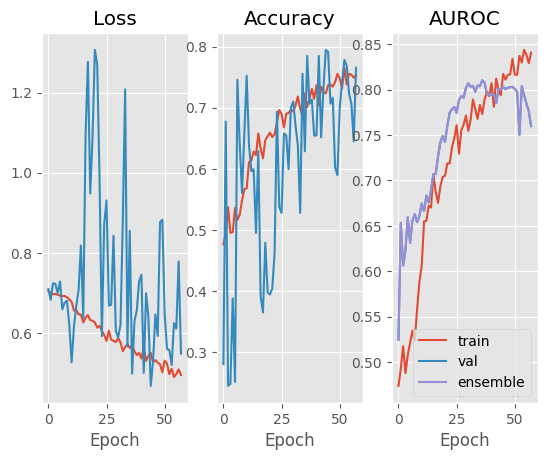

Early stop status: 0/10
Last 10 average Train Loss: 0.51062
Last 10 average Val   Loss: 0.6650200000000001
Saving metrics...

Undersampled Training Set
Continuing training with SE_ResNeXt50_32x4d_ER_Label
Epoch: 59/300


  0%|                                                                                   | 1/810 [00:04<57:49,  4.29s/it]


KeyboardInterrupt: 

In [20]:

# Restart from the previous checkpoint?
if restart:
    model, optimizer, start_epoch, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, sens, spec, early_stopper = load_ckp(ckp_path, model, optimizer)
    model.to(device)
    

else: 
    start_epoch = 1
    best_val_auc = 0
    best_val_auc_epoch = 0
    ensemble_improvement = []
    stats = [[],[],[],[],[],[],[]] # [train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs, ensemble_auc] 
    sens = 0
    spec = 0
    early_stopper = EarlyStopper(patience=10, min_delta=0.6)
if restart == True:
    print(f'Resuming {model.name} model from epoch: {start_epoch}')


try:
    ############## Save data ############
    checkpoint = create_checkpoint(epoch, model, optimizer, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, sens, spec, early_stopper)
    save_ckp(checkpoint, checkpoint_dir, False)
except NameError:
    pass

print(f'Start Training with {model.name}')
# print(f'Train set size: {len(df_cross_train)}, Val set size: {len(df_cross_val)}')
if df_test_train[label].value_counts().index.tolist()[0] == 1:
    class1, class0 = df_test_train[label].value_counts()
else:
    class0, class1 = df_test_train[label].value_counts()
c1 = df_test_train[df_test_train[label] == 1]
c0 = df_test_train[df_test_train[label] == 0]
sample = 'Und' # sampling type
s_num = 1

if sample == 'Ov':
     # Basic even sampling of training data using oversampling, based on the fewest label count
    if class0 >= class1:
        s_num = class0
    else: 
        s_num = class1
    replace = True  
else:
    # Basic even sampling of training data using undersampling, based on the fewest label count
    if class0 <= class1:
        s_num = class0
    else: 
        s_num = class1
    replace = False

df_1 = c1.sample(s_num, replace=replace)
df_0 = c0.sample(s_num, replace=replace)
df_epoch_train = pd.concat([df_1, df_0], axis=0)
df_epoch_train = df_epoch_train.reset_index(drop=True)
df_epoch_train[label].value_counts()   

# Begin training
for epoch in range(start_epoch, num_epochs + 1):        
    print(f'{sample}ersampled Training Set')
    
    
    if sample == 'Und':
        df_1 = c1.sample(s_num, replace=replace)
        df_0 = c0.sample(s_num, replace=replace)
        df_epoch_train = pd.concat([df_1, df_0], axis=0)
        df_epoch_train = df_epoch_train.reset_index(drop=True)
        # print(df_epoch_train[label].value_counts())
    if epoch > 1:
        print(f'Continuing training with {model.name}')
    # # Build training dataloader
    train_dataset = MILDataset(df_epoch_train, n_tiles, train_transform, False)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
    # train model
    train_loss, train_acc, train_auc = train(model, device, train_dataloader, optimizer, epoch)
    print(torch.cuda.max_memory_allocated(device=None) / (1024 ** 2))
    # Test the model on validation data
    print(f'Running {num_vals} tests on validation data.')
    losses = []
    accs = []
    aucs = []
    labels = []
    
    df_trials = pd.DataFrame()
    for run in range(num_vals): # Run several validations to account for random tile selections
        # Build validation dataloader
        val_dataset = MILDataset(df_test_val, n_tiles_val, test_transform, False)    
        val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
        val_loss, val_acc, val_auc, val_preds, val_labels, val_probs = validate(model, device, val_dataloader)
        losses.append(val_loss)
        accs.append(val_acc)
        aucs.append(val_auc)
        df_trials[run] = val_probs
        
        
    avg_val_loss = round(sum(losses) / len(losses), 4)
    avg_val_acc = round(sum(accs) / len(accs), 4)
    avg_val_auc = round(sum(aucs) / len(aucs), 4)
    time.sleep(5)
    if epoch < num_epochs:
        clear_output(wait=True)
    print(f'  Average validation scores: Loss = {avg_val_loss}, Acc = {avg_val_acc}, AUROC = {avg_val_auc}')

    # Ensemble prediction
    e_acc, e_roc_auc, sens, spec = test_metrics(df_test_val[label].tolist(), df_trials, e_choice, 'validation')
    print(f'Sensitivity: {round(sens, 3)}, Specificity: {round(spec, 3)}')
    improved = 100 * round(e_roc_auc - avg_val_auc,3)
    ensemble_improvement.append(improved)
    if avg_val_auc >= best_val_auc:
        best_val_auc = avg_val_auc
        best_val_auc_epoch = epoch
        is_best = True
        checkpoint = create_checkpoint(epoch, model, optimizer, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, sens, spec, early_stopper)
        save_ckp(checkpoint, checkpoint_dir, is_best)
    else:
         is_best = False   
    # print(f'Ensemble Accuracy: {e_acc}, AUROC: {e_roc_auc}, Improved by: {improved} points!')

    
    avg_e_improv = round(sum(ensemble_improvement) / len(ensemble_improvement),3)
    # print(f'Previous Epoch: Ensemble AUROC: {e_roc_auc} versus Average: {avg_val_auc}, Improved by: {improved} points!')

    print(f'Best average AUROC: {best_val_auc} at epoch: {best_val_auc_epoch} Average Ensemble Improvement: {avg_e_improv} points')

    stats[0].append(train_loss)
    stats[1].append(train_acc)
    stats[2].append(train_auc)
    stats[3].append(avg_val_loss)
    stats[4].append(avg_val_acc)
    stats[5].append(avg_val_auc)
    stats[6].append(e_roc_auc)

    # Plot the results
    figure, axis = plt.subplots(1, 3)
    axis[0].plot(range(epoch), stats[0], label = 'train')
    axis[0].plot(range(epoch), stats[3], label = 'val')
    axis[0].set_title('Loss')
    axis[0].set_xlabel('Epoch')
    axis[1].plot(range(epoch), stats[1], label = 'train')
    axis[1].plot(range(epoch), stats[4], label = 'val')
    axis[1].set_title('Accuracy')
    axis[1].set_xlabel('Epoch')
    axis[2].plot(range(epoch), stats[2], label = 'train')
    axis[2].plot(range(epoch), stats[5], label = 'val')
    axis[2].plot(range(epoch), stats[6], label = 'ensemble')
    axis[2].set_title('AUROC')
    axis[2].set_xlabel('Epoch')
    plt.legend()
    plt.savefig(f'figures/Test_{model.name}.png')
    plt.show()

    early_stopper.print_stop_status()

    # Save metrics
    print(f'Saving metrics...')
    checkpoint = create_checkpoint(epoch + 1, model, optimizer, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, sens, spec, early_stopper)
    save_ckp(checkpoint, checkpoint_dir, False)
    if early_stopper.early_stop(avg_val_loss, train_loss):             
        break
    
    print()

## Ensemble Experiment

In [25]:
##### Test the model on test data
   
df = df_test
ckp_path = f"checkpoints/best_checkpoint-{date}_{label}.pt"
model, optimizer, start_epoch, stats, best_val_auc, best_val_auc_epoch, ensemble_improvement, sens, spec, early_stopper = load_ckp(ckp_path, model, optimizer)
model.to(device)
trail_tile_count = 50
base_count = 500
blue_color = '\033[94m'
green_code = '\033[92m'
reset_color = '\033[0m'
runs = 5

if class1 < class0:
    e_choice = 'max'
elif class0 < class1:
    e_choice = 'min'
else:
    e_choice = 'avg'

e_choice = 'max'
print(f' Utilizing Ensemble with {e_choice} chooser.')

# print('Initialize Model with Small Bag Size')
# test_dataset = MILDataset(df, 3, test_transform, False)    
# test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
# test_loss, base_test_acc, base_test_auc, test_infer, base_test_labels, base_test_probs = validate(model, device, test_dataloader)

print('Running Base Test')
test_dataset = MILDataset(df, base_count, test_transform, False)    
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loss, base_test_acc, base_test_auc, test_infer, base_test_labels, base_test_probs = validate(model, device, test_dataloader)


stats = [[], [], [], [], [], [], []]
for j in range(runs):
    num_val = int(base_count / trail_tile_count)
    print(f'Running {runs} tests on test data.')
    print(f'Ensemble {j+1}/{runs}')
    losses = []
    accs = []
    aucs = []
    labels = []
    df_trials = pd.DataFrame()
    tic = time.time()
    for run in range(num_val): # Run several validations to account for random tile selections
        # Build validation dataloader
        val_dataset = MILDataset(df, trail_tile_count, test_transform, False)    
        val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
        # val_loss, val_acc, val_auc, df_trials[run], val_labels, val_probs = validate(model, device, val_dataloader)
        val_loss, val_acc, val_auc, val_preds, val_labels, df_trials[run] = validate(model, device, val_dataloader)
        losses.append(val_loss)
        accs.append(val_acc)
        aucs.append(val_auc)
        
    toc = time.time()
    
    avg_val_acc = round(sum(accs) / len(accs), 4)
    avg_val_auc = round(sum(aucs) / len(aucs), 4)

    # Ensemble prediction
    e_acc, e_roc_auc, sens, spec = test_metrics(df[label].tolist(), df_trials, e_choice, 'test')
    print(f'Sensitivity: {sens}, Specificity: {spec}')        
    stats[0].append(toc - tic)
    stats[1].append(e_acc)
    stats[2].append(e_roc_auc)
    stats[3].append(sens)
    stats[4].append(spec)
    stats[5].append(e_acc - base_test_acc)
    stats[6].append(e_roc_auc - base_test_auc)

    clear_output(wait=True)
    print(f'Base Accuracy: {round(base_test_acc, 3)}')
    print(f'Base AUROC:    {round(base_test_auc, 3)}')
    print(f'Time to run ensemble with {num_val} tests: {round(stats[0][len(stats[0])-1], 3)} sec')
    print(f'Average Accuracy  : {round(sum(accs) / len(accs), 3)}')
    print(f'Average AUROC     : {round(sum(aucs) / len(aucs), 3)}')
    print(f'Ensemble Accuracy : {round(stats[1][len(stats[1])-1], 3)}')
    print(f'Ensemble AUROC    : {round(stats[2][len(stats[2])-1], 3)}')
    print(f'Ensemble Sensitiv : {round(stats[3][len(stats[3])-1], 3)}')
    print(f'Ensemble Specitiv : {round(stats[4][len(stats[4])-1], 3)}')
    print(f'Ensemble Accuracy Improvement: {100 * round(stats[5][len(stats[5])-1], 3)} points')
    print(f'Ensemble AUROC    Improvement: {100 * round(stats[6][len(stats[6])-1], 3)} points')
    print()

avg_acc_imp = sum(stats[5]) / len(stats[5])
avg_auc_imp = sum(stats[6]) / len(stats[6])
avg_e_acc = sum(stats[1]) / len(stats[1])
avg_e_auc = sum(stats[2]) / len(stats[2])
print(f'{green_code}')
print(f'Average time to run ensemble with {num_val} members: {round(sum(stats[0]) / len(stats[0]),3)}')
print(f'Average snsemble Accuracy: {round(avg_e_acc, 3)}')
print(f'Average ensemble AUROC   : {round(avg_e_auc, 3)}')
print(f'Average ensemble Sensi   : {round(sum(stats[3]) / len(stats[3]), 3)}')
print(f'Average ensemble Speci   : {round(sum(stats[4]) / len(stats[4]), 3)}')
print(f'Average Ensemble Accuracy Improvement: {100 * round(avg_acc_imp, 3)} points!')
print(f'Average Ensemble AUROC    Improvement: {100 * round(avg_auc_imp, 3)} points!')
print(f'{reset_color}')
print()

Base Accuracy: 0.777
Base AUROC:    0.803
Time to run ensemble with 10 tests: 399.699 sec
Average Accuracy  : 0.769
Average AUROC     : 0.796
Ensemble Accuracy : 0.74
Ensemble AUROC    : 0.796
Ensemble Sensitiv : 0.73
Ensemble Specitiv : 0.773
Ensemble Accuracy Improvement: -3.6999999999999997 points
Ensemble AUROC    Improvement: -0.7000000000000001 points


Average time to run ensemble with 10 members: 400.609
Average snsemble Accuracy: 0.756
Average ensemble AUROC   : 0.798
Average ensemble Sensi   : 0.755
Average ensemble Speci   : 0.761
Average Ensemble Accuracy Improvement: -2.1 points!
Average Ensemble AUROC    Improvement: -0.5 points!




In [43]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(val_labels, base_test_probs)

# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr

# Find the threshold that maximizes Youden's J statistic
best_threshold = thresholds[np.argmax(youden_j)]
best_threshold

0.39453125

In [41]:
binarized_array = np.where(np.array(val_probs) >= best_threshold, 1, 0)
print(100*round(accuracy(binarized_array, val_labels),4))
confusion_matrix(val_labels, binarized_array)

55.37


array([[ 59,  12],
       [125, 111]])